In [1]:
import pandas as pd
import statsmodels.api as sm

# Load your data
df = pd.read_csv("multi_season_team_summary.csv")

# Only use seasons where we know playoff results
train_df = df[df["cup_winner"].notnull()].copy()

# Step 1: Create Enhanced Features
train_df["goal_efficiency"] = train_df["goal_diff"] / train_df["wins"].replace(0, 1)  # avoid division by zero
train_df["offensive_power"] = train_df["goal_diff"] + (train_df["wins"] * 2)
train_df["elo_x_win_pct"] = train_df["elo"] * train_df["win_pct"]

# Step 2: Define Features for New Regression
features = ["wins", "goal_diff", "win_pct", "elo", "playoff_games", 
            "goal_efficiency", "offensive_power", "elo_x_win_pct"]

# Note: We're still trying to predict playoff_games

X = train_df[["wins", "goal_diff", "win_pct", "elo", "goal_efficiency", "offensive_power", "elo_x_win_pct"]]
X = sm.add_constant(X)  # add intercept
y = train_df["playoff_games"]

# Step 3: Fit Linear Regression Model
model = sm.OLS(y, X).fit()

# Step 4: Output Results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          playoff_games   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     45.74
Date:                Sat, 26 Apr 2025   Prob (F-statistic):           9.12e-29
Time:                        11:01:39   Log-Likelihood:                -351.02
No. Observations:                 127   AIC:                             716.0
Df Residuals:                     120   BIC:                             736.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const             -30.5795     50.533     

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

features = ["wins", "goal_diff", "win_pct", "elo", "playoff_games",
            "goal_efficiency", "offensive_power", "elo_x_win_pct"]

# Compute the correlation matrix
corr_matrix = train_df[features].corr()


In [21]:
corr_matrix

,wins,goal_diff,win_pct,elo,playoff_games,goal_efficiency,offensive_power,elo_x_win_pct
wins,1.000000,0.807392,0.823074,0.823854,0.732978,0.742987,0.914806,0.834632
goal_diff,0.807392,1.000000,0.939755,0.930753,0.710269,0.933593,0.976911,0.943371
win_pct,0.823074,0.939755,1.000000,0.950282,0.703863,0.921844,0.941348,0.996898
elo,0.823854,0.930753,0.950282,1.000000,0.776261,0.879929,0.935469,0.966628
playoff_games,0.732978,0.710269,0.703863,0.776261,1.000000,0.585351,0.751630,0.734769
goal_efficiency,0.742987,0.933593,0.921844,0.879929,0.585351,1.000000,0.908130,0.905787
offensive_power,0.914806,0.976911,0.941348,0.935469,0.751630,0.908130,1.000000,0.948009
elo_x_win_pct,0.834632,0.943371,0.996898,0.966628,0.734769,0.905787,0.948009,1.000000


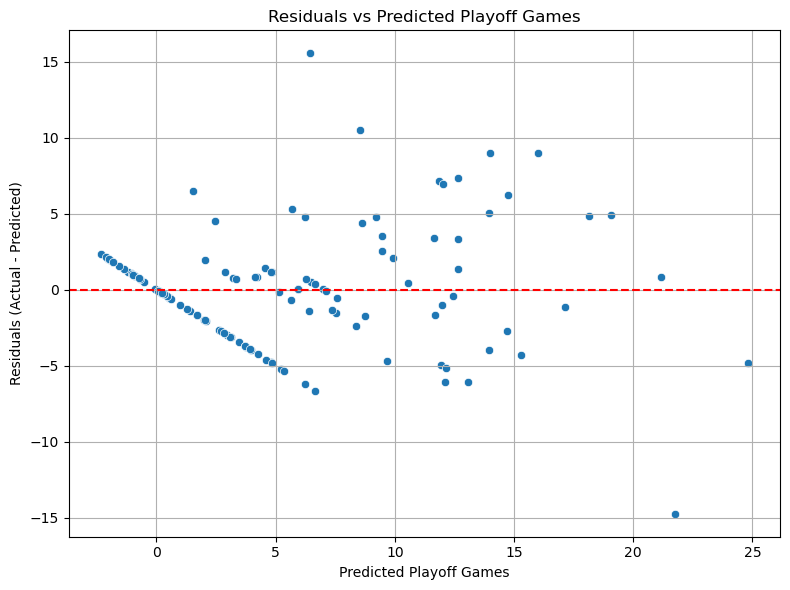

In [7]:
# Make sure these imports are at the top
import matplotlib.pyplot as plt
import seaborn as sns

# Plot residuals correctly
plt.figure(figsize=(8, 6))
sns.scatterplot(x=train_df["predicted_playoff_games"], y=train_df["residuals"])
plt.axhline(0, linestyle='--', color='red')
plt.title("Residuals vs Predicted Playoff Games")
plt.xlabel("Predicted Playoff Games")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()



In [5]:
# Predict for 2024–2025 teams
predict_df = df[df["season"] == "2024-2025"].copy()

# Recalculate enhanced features for 2024–25 teams
predict_df["goal_efficiency"] = predict_df["goal_diff"] / predict_df["wins"].replace(0, 1)
predict_df["offensive_power"] = predict_df["goal_diff"] + (predict_df["wins"] * 2)
predict_df["elo_x_win_pct"] = predict_df["elo"] * predict_df["win_pct"]

# Prepare features
X_predict = predict_df[["wins", "goal_diff", "win_pct", "elo", "goal_efficiency", "offensive_power", "elo_x_win_pct"]]
X_predict = sm.add_constant(X_predict)

# Predict playoff games
predict_df["predicted_playoff_games"] = model.predict(X_predict)

# Rank teams based on predicted playoff games
predict_df = predict_df.sort_values(by="predicted_playoff_games", ascending=False)

# Display top 10
print("\n🏆 Top 10 Predicted Teams Based on Playoff Games Model:")
print(predict_df[["team", "wins", "goal_diff", "elo", "win_pct", "predicted_playoff_games"]].head(10))



🏆 Top 10 Predicted Teams Based on Playoff Games Model:
    team  wins  goal_diff   elo   win_pct  predicted_playoff_games
136  TOR    55         43  1632  0.647059                15.987236
140  WPG    58         84  1621  0.682353                15.578738
145  LAK    50         46  1583  0.588235                11.332522
130  STL    45         23  1562  0.529412                 9.363148
144  COL    50         45  1559  0.588235                 9.229757
150  DAL    52         51  1550  0.611765                 8.459052
139  EDM    49         21  1552  0.576471                 8.448693
131  FLA    49         35  1550  0.583333                 8.287889
143  VGK    51         52  1547  0.600000                 8.219021
157  WSH    53         56  1545  0.623529                 8.031537


In [55]:
# Sort again just to be sure
predict_df = predict_df.sort_values(by="predicted_playoff_games", ascending=False)

# Create a Rank column (1 = best)
predict_df["predicted_rank"] = range(1, len(predict_df) + 1)

# Display top 10 neatly
print("\nTop 10 Predicted Teams Based on Playoff Games Model (Ranked):")
print(predict_df[["predicted_rank", "team", "wins", "goal_diff", "elo", "win_pct", "predicted_playoff_games"]].head(10))



Top 10 Predicted Teams Based on Playoff Games Model (Ranked):
     predicted_rank team  wins  goal_diff   elo   win_pct  \
136               1  TOR    55         43  1632  0.647059   
140               2  WPG    58         84  1621  0.682353   
145               3  LAK    50         46  1583  0.588235   
130               4  STL    45         23  1562  0.529412   
144               5  COL    50         45  1559  0.588235   
150               6  DAL    52         51  1550  0.611765   
139               7  EDM    49         21  1552  0.576471   
131               8  FLA    49         35  1550  0.583333   
143               9  VGK    51         52  1547  0.600000   
157              10  WSH    53         56  1545  0.623529   

     predicted_playoff_games  
136                15.987236  
140                15.578738  
145                11.332522  
130                 9.363148  
144                 9.229757  
150                 8.459052  
139                 8.448693  
131              

In [23]:
# After sorting and adding financial predictions

# Save it cleanly for final use
predict_df.to_csv("2024_2025_predictions_with_revenue_FINAL.csv", index=False)

print("\n✅ Final Predictions Saved Successfully!")



✅ Final Predictions Saved Successfully!


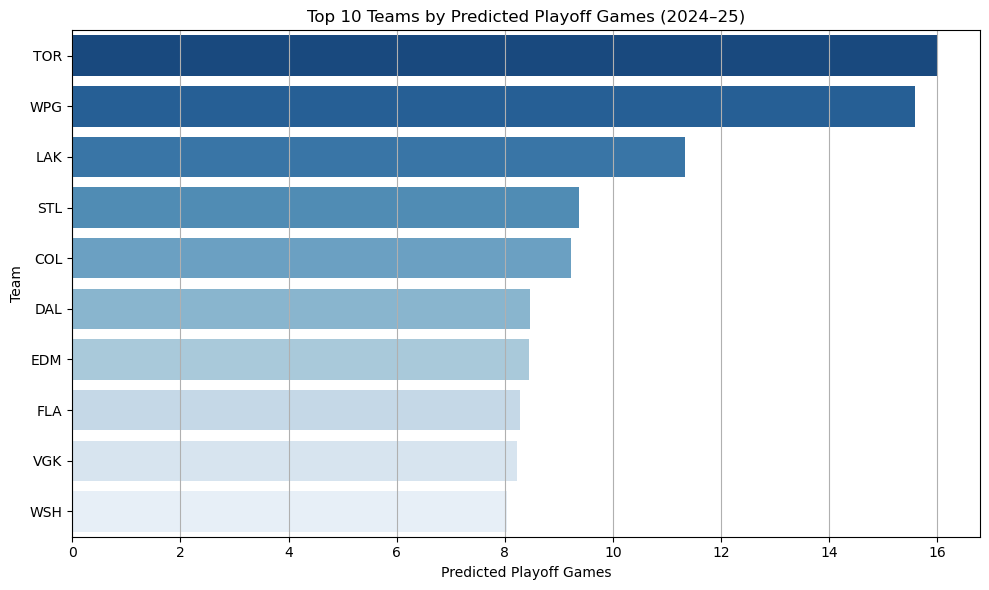

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Just in case, make sure data is sorted
predict_df = predict_df.sort_values(by="predicted_playoff_games", ascending=False)

# Take Top 10
top10 = predict_df.head(10)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10,
    x="predicted_playoff_games",
    y="team",
    palette="Blues_r"
)

plt.title("Top 10 Teams by Predicted Playoff Games (2024–25)")
plt.xlabel("Predicted Playoff Games")
plt.ylabel("Team")
plt.grid(axis="x")
plt.tight_layout()
plt.show()


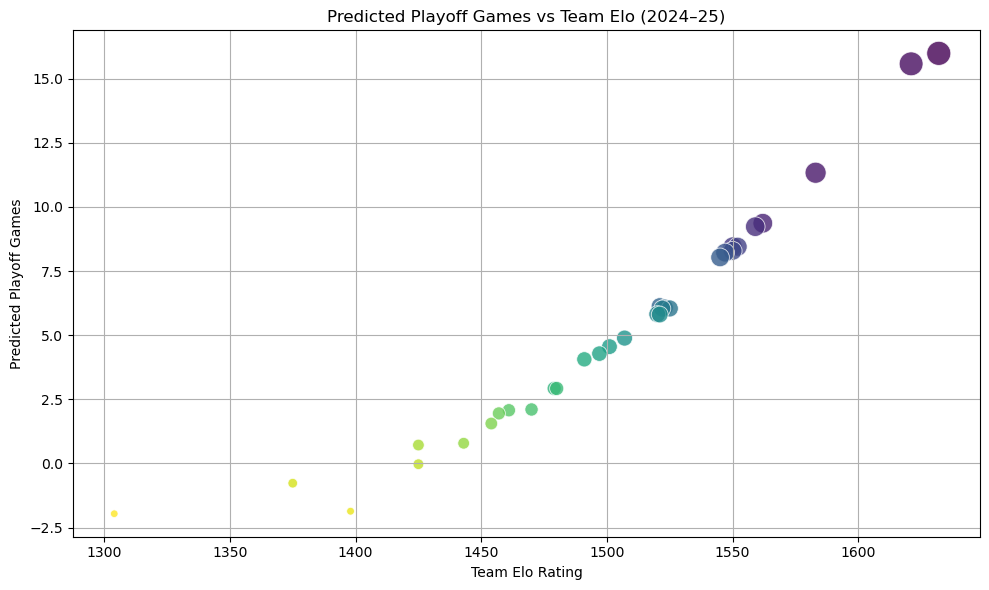

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=predict_df,
    x="elo",
    y="predicted_playoff_games",
    hue="predicted_rank",
    palette="viridis",
    size="predicted_playoff_games",
    sizes=(30, 300),
    alpha=0.8,
    legend=False
)

plt.title("Predicted Playoff Games vs Team Elo (2024–25)")
plt.xlabel("Team Elo Rating")
plt.ylabel("Predicted Playoff Games")
plt.grid(True)
plt.tight_layout()
plt.show()


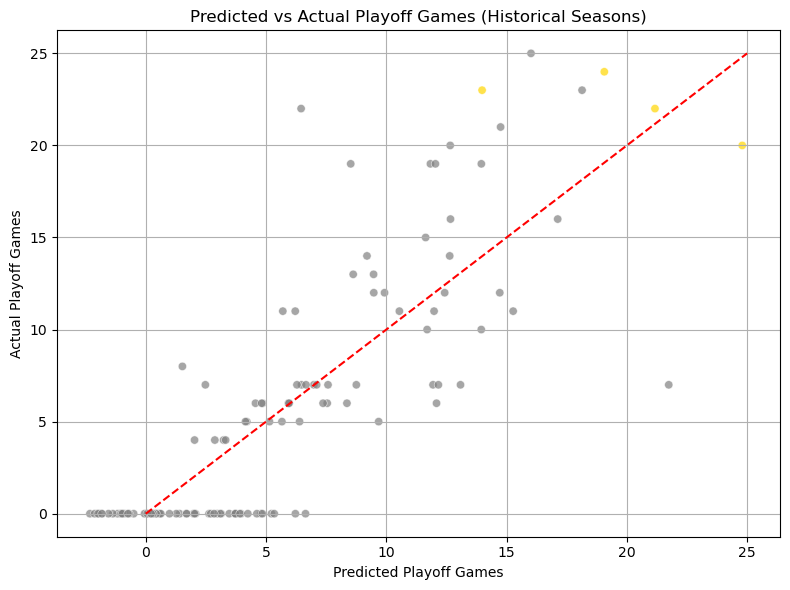

In [15]:
# Only for historical seasons (2020–2024) where we know actual playoff games
train_df["predicted_playoff_games"] = model.predict(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=train_df["predicted_playoff_games"],
    y=train_df["playoff_games"],
    hue=train_df["cup_winner"],
    palette={0: "gray", 1: "gold"},
    alpha=0.7,
    legend=False
)

plt.plot([0, max(train_df["playoff_games"])], [0, max(train_df["playoff_games"])], color='red', linestyle='--')
plt.title("Predicted vs Actual Playoff Games (Historical Seasons)")
plt.xlabel("Predicted Playoff Games")
plt.ylabel("Actual Playoff Games")
plt.grid(True)
plt.tight_layout()
plt.show()


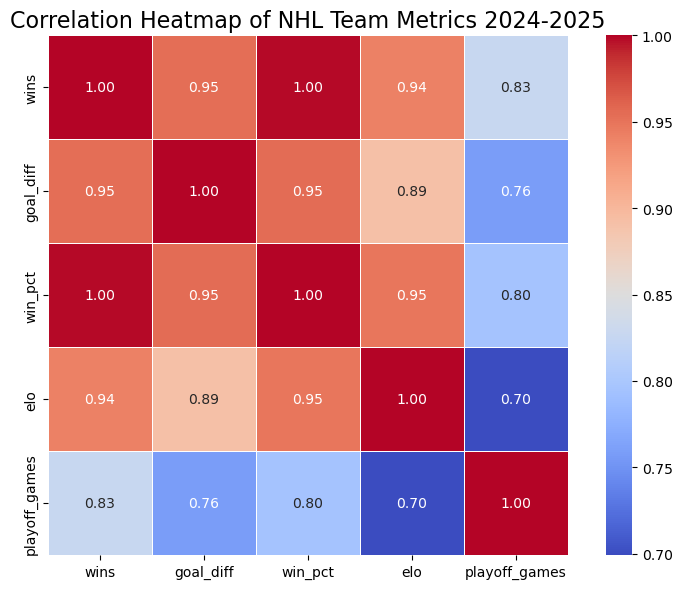

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
df = pd.read_csv("2024_2025_predictions.csv")

# Pick features for correlation
features = ["wins", "goal_diff", "win_pct", "elo", "playoff_games"]

# Compute the correlation matrix
corr = df[features].corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, square=True)
plt.title("Correlation Heatmap of NHL Team Metrics 2024-2025", fontsize=16)
plt.tight_layout()
plt.show()


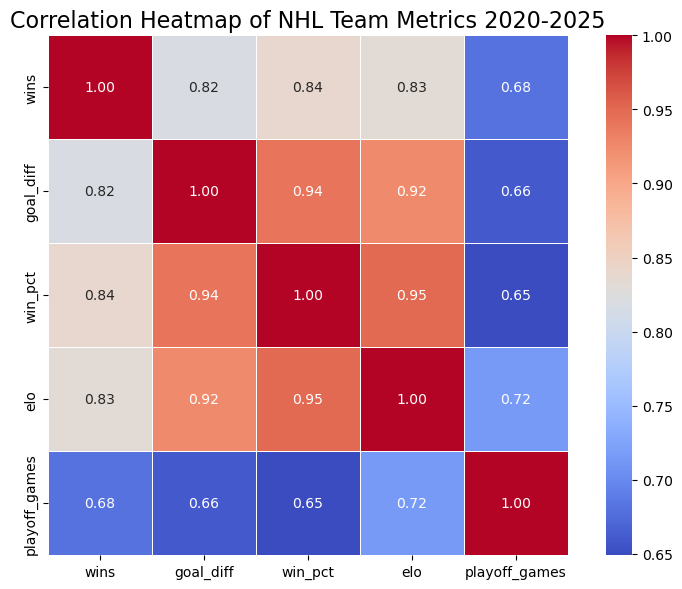

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your full multi-season dataset
df = pd.read_csv("multi_season_team_summary.csv")

# Pick features for correlation
features = ["wins", "goal_diff", "win_pct", "elo", "playoff_games"]

# Compute the correlation matrix
corr = df[features].corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5, square=True)
plt.title("Correlation Heatmap of NHL Team Metrics 2020-2025", fontsize=16)
plt.tight_layout()
plt.show()


In [43]:
df.head()

,team,season,games_played,playoff_games,wins,losses,goals_for,goals_against,goal_diff,win_pct,elo,cup_winner,goal_efficiency,offensive_power,elo_x_win_pct,predicted_playoff_games,predicted_rank
0,TOR,2024-2025,85,3,55,30,280,237,43,0.647059,1632,NaN,0.781818,153,1056.000001,15.987236,1
1,WPG,2024-2025,85,3,58,27,286,202,84,0.682353,1621,NaN,1.448276,200,1106.094117,15.578738,2
2,LAK,2024-2025,85,3,50,35,266,220,46,0.588235,1583,NaN,0.920000,146,931.176470,11.332522,3
3,STL,2024-2025,85,3,45,40,265,242,23,0.529412,1562,NaN,0.511111,113,826.941177,9.363148,4
4,COL,2024-2025,85,3,50,35,286,241,45,0.588235,1559,NaN,0.900000,145,917.058823,9.229757,5


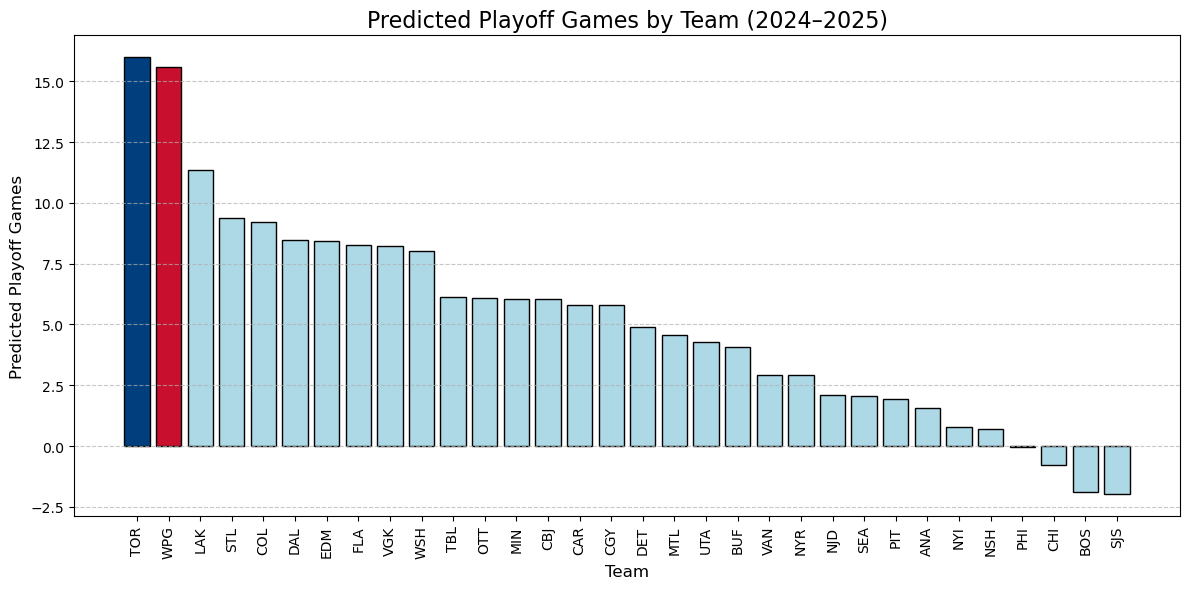

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Load predictions
df = pd.read_csv("2024_2025_predictions_with_revenue_FINAL.csv")

# Sort by playoff predictions
df = df.sort_values(by="predicted_playoff_games", ascending=False)

# Define colors
colors = []
for team in df["team"]:
    if team == "TOR":
        colors.append("#003E7E")   # Toronto Blue
    elif team == "WPG":
        colors.append("#C8102E")   # Winnipeg Red (Accent Color)
    else:
        colors.append("lightblue") # Default color for others

# Create bar chart
plt.figure(figsize=(12,6))
bars = plt.bar(df["team"], df["predicted_playoff_games"], color=colors, edgecolor="black")

plt.title("Predicted Playoff Games by Team (2024–2025)", fontsize=16)
plt.xlabel("Team", fontsize=12)
plt.ylabel("Predicted Playoff Games", fontsize=12)
plt.xticks(rotation=90)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
